In [1]:
# Notebook to simulate diffusion equation for the MHD systems

In [2]:
# import cupy
import cupy as np ## USsing GPU to run the simulations
import matplotlib.pyplot as plt
import os
import sys
from tqdm.auto import tqdm
from util import *

In [3]:
PATH = "./Parameters.json"

In [4]:
def B_r_f(r):
    return -(r-5)**(2)  + 25
    # return 0.8*np.sin(0.1*np.pi*r) + 0.1*np.sin(0.7*np.pi*r)

def B_phi_f(r):
    return (r - 5)**(2) - 25
    # return -(0.8*np.sin(0.1*np.pi*r) + 0.1*np.sin(0.7*np.pi*r))

def alpha_f(r):
    return np.ones_like(r)*7

def omega_f(r):
    return 10/np.sqrt(1+(r/4)**2)


def V_r_f(r):
    return r*0
def V_z_f(r):
    return r*0

In [5]:
B_r_t,Bphi_t,r,dr,omega,alpha,V_r,V_z,h,eta,dt,d_t,t_min,r_index,grad_omega,grad_V_r,D = init(PATH,
                                                                                              B_r_f=B_r_f,
                                                                                              B_phi_f=B_phi_f,
                                                                                              alpha_f=alpha_f,
                                                                                              omega_f=omega_f,
                                                                                              V_r_f=V_r_f,
                                                                                              V_z_f=V_z_f)

B_r_evolution = []
B_phi_evolution = []
time = []
time_evol = []
B_r_decay = []
B_phi_decay = []

------------------Parameters------------------
h_val: 0.1
eta_m: 0.01
eta_t: 0
r_min: 1e-07
t_min: 0
r_max: 10
t_max: 10
d_r: 0.01
d_t: 0.01
------------------------------------------------


In [6]:
for i in tqdm(range(len(dt))):
    time_step = dt[i]
    if i%20 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
        time_evol.append(t_min + i*np.abs(d_t))
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t,
                                    Bphi_t,r=r,
                                    dr=dr,
                                    dt=time_step,
                                    omega=omega,
                                    alpha=alpha,
                                    V_r=V_r,
                                    V_z=V_z,
                                    h=h,
                                    eta=eta,
                                    grad_omega=grad_omega,
                                    grad_V_r=grad_V_r
                                   )



  0%|          | 0/1001 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Dynamo Number -201.13926258197816')

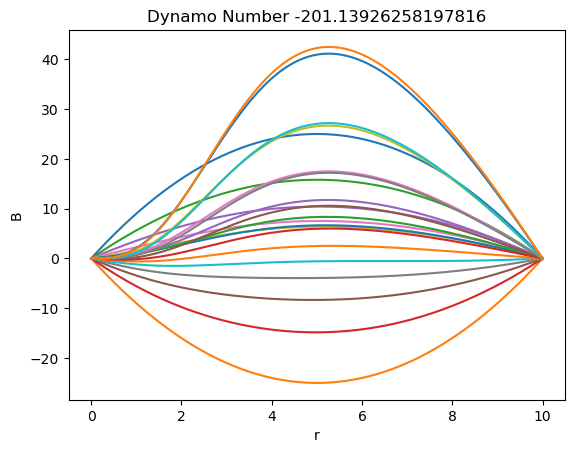

In [7]:
#Unscaled --->

for i in range(0,len(B_r_evolution),5):
    plt.plot(r.get(),B_r_evolution[i].get())
    plt.plot(r.get(),B_phi_evolution[i].get())
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"Dynamo Number {D.item()}")

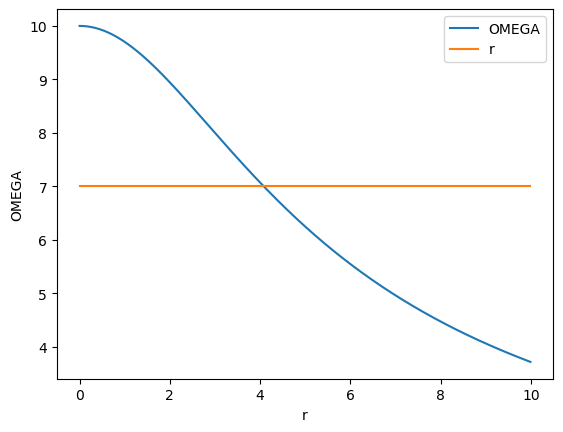

In [8]:
plt.plot(r.get(), omega_f(r).get(), label="OMEGA")
plt.plot(r.get(), alpha_f(r).get(), label=r"r")
plt.xlabel("r")
plt.ylabel("OMEGA")
plt.legend()


Text(0.5, 1.0, 'Pitch Angle')

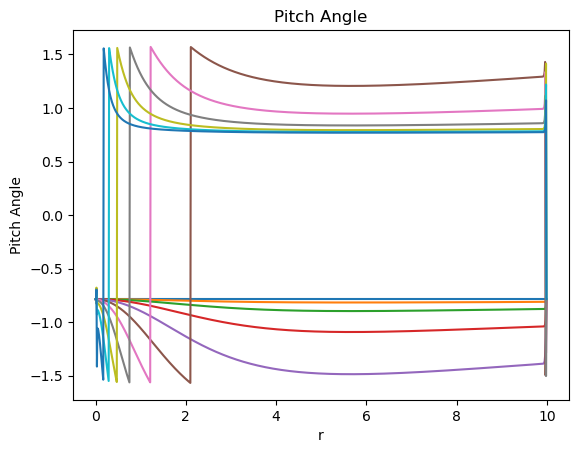

In [9]:
for i in range(0,len(B_r_evolution),5):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r.get(), np.arctan(B_r_evolution[i]/B_phi_evolution[i]).get())
plt.title("Pitch Angle")    

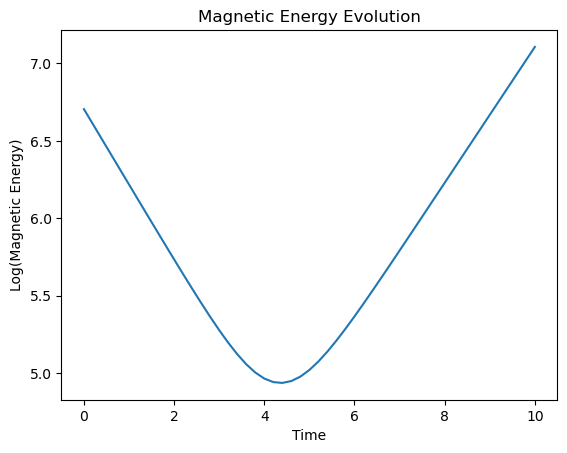

In [10]:
B_ener = []
for i in range(len(B_r_evolution)):
    B_tot = np.sqrt(np.sum(B_r_evolution[i]**2 + B_phi_evolution[i]**2))
    B_ener.append(B_tot)
    
plt.plot(np.array(time_evol).get(), np.log(np.array(B_ener)).get())
plt.xlabel("Time")
plt.ylabel("Log(Magnetic Energy)")
plt.title("Magnetic Energy Evolution")

B1 = B_ener
D1 = D
Br1_loc = B_r_decay
Bphi1_loc = B_phi_decay

In [11]:
def B_r_f(r):
    return -(r-5)**(2)  + 25
    # return 0.8*np.sin(0.1*np.pi*r) + 0.1*np.sin(0.7*np.pi*r)

def B_phi_f(r):
    return (r - 5)**(2) - 25
    # return -(0.8*np.sin(0.1*np.pi*r) + 0.1*np.sin(0.7*np.pi*r))

def alpha_f(r):
    return np.ones_like(r)*10

def omega_f(r):
    return 10/np.sqrt(1+(r/4)**2)


def V_r_f(r):
    return r*0
def V_z_f(r):
    return r*0

In [12]:
B_r_t,Bphi_t,r,dr,omega,alpha,V_r,V_z,h,eta,dt,d_t,t_min,r_index,grad_omega,grad_V_r,D = init(PATH,
                                                                                              B_r_f=B_r_f,
                                                                                              B_phi_f=B_phi_f,
                                                                                              alpha_f=alpha_f,
                                                                                              omega_f=omega_f,
                                                                                              V_r_f=V_r_f,
                                                                                              V_z_f=V_z_f)

B_r_evolution = []
B_phi_evolution = []
time = []
time_evol = []
B_r_decay = []
B_phi_decay = []

------------------Parameters------------------
h_val: 0.1
eta_m: 0.01
eta_t: 0
r_min: 1e-07
t_min: 0
r_max: 10
t_max: 10
d_r: 0.01
d_t: 0.01
------------------------------------------------


In [13]:
for i in tqdm(range(len(dt))):
    time_step = dt[i]
    if i%20 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
        time_evol.append(t_min + i*np.abs(d_t))
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t,
                                    Bphi_t,r=r,
                                    dr=dr,
                                    dt=time_step,
                                    omega=omega,
                                    alpha=alpha,
                                    V_r=V_r,
                                    V_z=V_z,
                                    h=h,
                                    eta=eta,
                                    grad_omega=grad_omega,
                                    grad_V_r=grad_V_r
                                   )



  0%|          | 0/1001 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Dynamo Number -287.34180368854027')

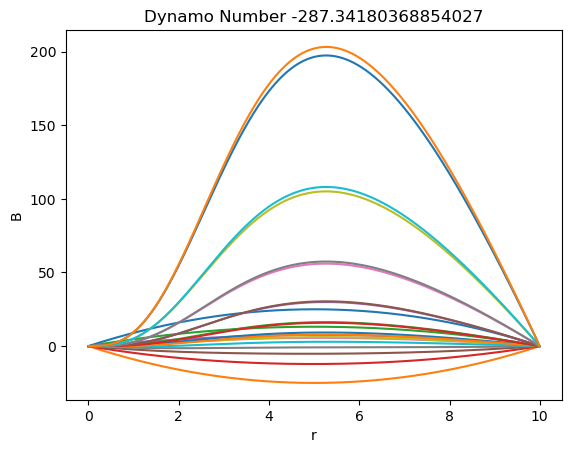

In [14]:
#Unscaled --->

for i in range(0,len(B_r_evolution),5):
    plt.plot(r.get(),B_r_evolution[i].get())
    plt.plot(r.get(),B_phi_evolution[i].get())
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"Dynamo Number {D.item()}")

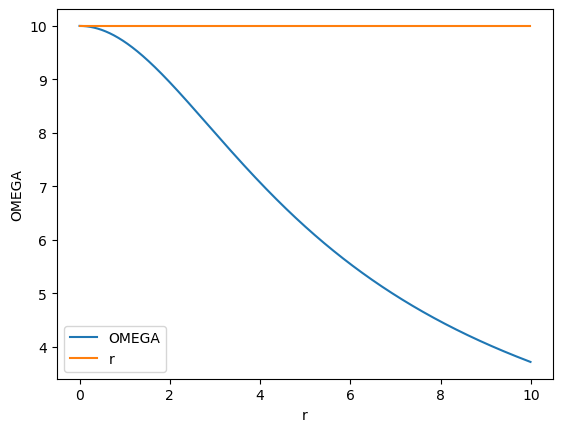

In [15]:
plt.plot(r.get(), omega_f(r).get(), label="OMEGA")
plt.plot(r.get(), alpha_f(r).get(), label=r"r")
plt.xlabel("r")
plt.ylabel("OMEGA")
plt.legend()


Text(0.5, 1.0, 'Pitch Angle')

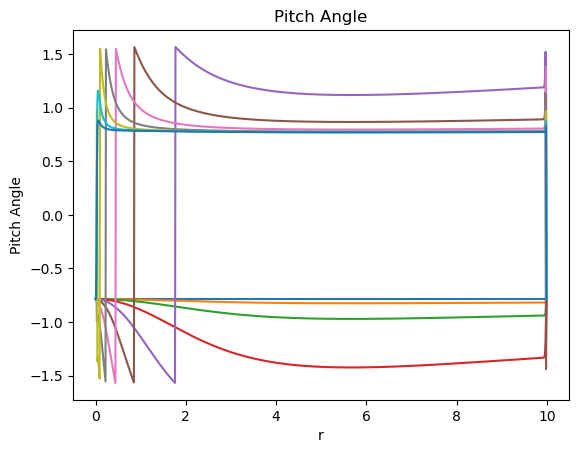

In [16]:
for i in range(0,len(B_r_evolution),5):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r.get(), np.arctan(B_r_evolution[i]/B_phi_evolution[i]).get())
plt.title("Pitch Angle")    

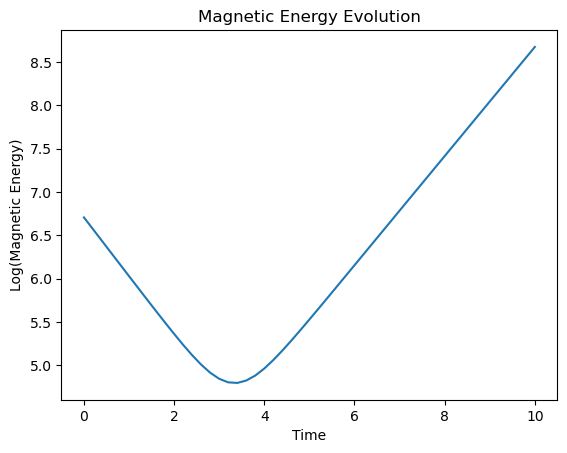

In [17]:
B_ener = []
for i in range(len(B_r_evolution)):
    B_tot = np.sqrt(np.sum(B_r_evolution[i]**2 + B_phi_evolution[i]**2))
    B_ener.append(B_tot)
    
plt.plot(np.array(time_evol).get(), np.log(np.array(B_ener)).get())
plt.xlabel("Time")
plt.ylabel("Log(Magnetic Energy)")
plt.title("Magnetic Energy Evolution")

B2 = B_ener
D2 = D
Br2_loc = B_r_decay
Bphi2_loc = B_phi_decay

In [18]:
def B_r_f(r):
    return -(r-5)**(2)  + 25
    # return 0.8*np.sin(0.1*np.pi*r) + 0.1*np.sin(0.7*np.pi*r)

def B_phi_f(r):
    return (r - 5)**(2) - 25
    # return -(0.8*np.sin(0.1*np.pi*r) + 0.1*np.sin(0.7*np.pi*r))

def alpha_f(r):
    return np.ones_like(r)*2

def omega_f(r):
    return 10/np.sqrt(1+(r/4)**2)


def V_r_f(r):
    return r*0
def V_z_f(r):
    return r*0

In [19]:
B_r_t,Bphi_t,r,dr,omega,alpha,V_r,V_z,h,eta,dt,d_t,t_min,r_index,grad_omega,grad_V_r,D = init(PATH,
                                                                                              B_r_f=B_r_f,
                                                                                              B_phi_f=B_phi_f,
                                                                                              alpha_f=alpha_f,
                                                                                              omega_f=omega_f,
                                                                                              V_r_f=V_r_f,
                                                                                              V_z_f=V_z_f)

B_r_evolution = []
B_phi_evolution = []
time = []
time_evol = []
B_r_decay = []
B_phi_decay = []

------------------Parameters------------------
h_val: 0.1
eta_m: 0.01
eta_t: 0
r_min: 1e-07
t_min: 0
r_max: 10
t_max: 10
d_r: 0.01
d_t: 0.01
------------------------------------------------


In [20]:
for i in tqdm(range(len(dt))):
    time_step = dt[i]
    if i%20 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
        time_evol.append(t_min + i*np.abs(d_t))
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t,
                                    Bphi_t,r=r,
                                    dr=dr,
                                    dt=time_step,
                                    omega=omega,
                                    alpha=alpha,
                                    V_r=V_r,
                                    V_z=V_z,
                                    h=h,
                                    eta=eta,
                                    grad_omega=grad_omega,
                                    grad_V_r=grad_V_r
                                   )



  0%|          | 0/1001 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Dynamo Number -57.468360737708046')

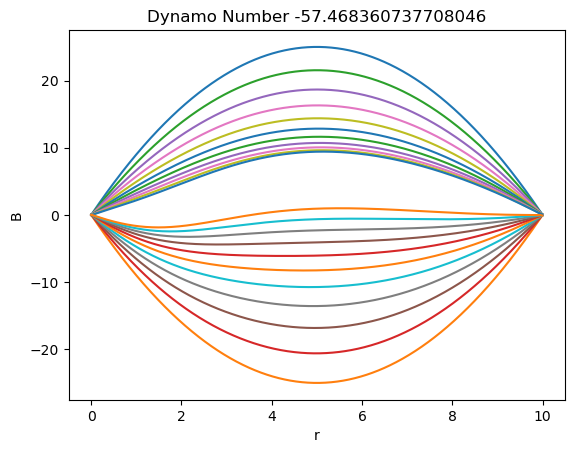

In [21]:
#Unscaled --->

for i in range(0,len(B_r_evolution),5):
    plt.plot(r.get(),B_r_evolution[i].get())
    plt.plot(r.get(),B_phi_evolution[i].get())
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"Dynamo Number {D.item()}")

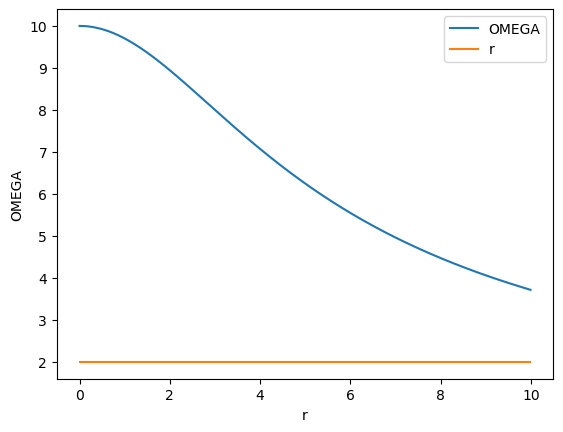

In [22]:
plt.plot(r.get(), omega_f(r).get(), label="OMEGA")
plt.plot(r.get(), alpha_f(r).get(), label=r"r")
plt.xlabel("r")
plt.ylabel("OMEGA")
plt.legend()


Text(0.5, 1.0, 'Pitch Angle')

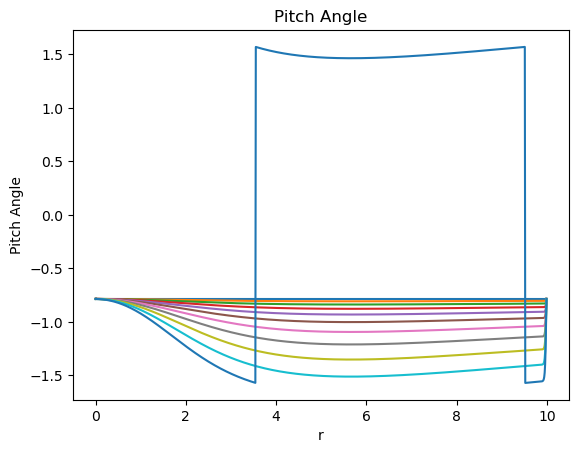

In [23]:
for i in range(0,len(B_r_evolution),5):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r.get(), np.arctan(B_r_evolution[i]/B_phi_evolution[i]).get())
plt.title("Pitch Angle")    

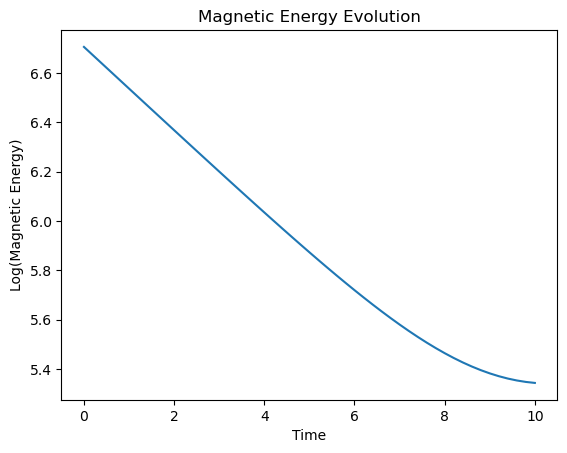

In [24]:
B_ener = []
for i in range(len(B_r_evolution)):
    B_tot = np.sqrt(np.sum(B_r_evolution[i]**2 + B_phi_evolution[i]**2))
    B_ener.append(B_tot)
    
plt.plot(np.array(time_evol).get(), np.log(np.array(B_ener)).get())
plt.xlabel("Time")
plt.ylabel("Log(Magnetic Energy)")
plt.title("Magnetic Energy Evolution")

B3 = B_ener
D3 = D
Br3_loc = B_r_decay
Bphi3_loc = B_phi_decay